<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Utility Functions</a></span></li><li><span><a href="#Experiment-1:-Can-we-find-the-true-GIA-model-when-GMSL-is-not-equal-to-Wael?" data-toc-modified-id="Experiment-1:-Can-we-find-the-true-GIA-model-when-GMSL-is-not-equal-to-Wael?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Experiment 1: Can we find the true GIA model when GMSL is not equal to Wael?</a></span><ul class="toc-item"><li><span><a href="#True-GIA-Model:" data-toc-modified-id="True-GIA-Model:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>True GIA Model:</a></span></li><li><span><a href="#Look-at-TRUE-GIA-model-output" data-toc-modified-id="Look-at-TRUE-GIA-model-output-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Look at TRUE GIA model output</a></span></li><li><span><a href="#Generate-'data'-from-true-GIA-model-(varying-age-and-location)." data-toc-modified-id="Generate-'data'-from-true-GIA-model-(varying-age-and-location).-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Generate 'data' from true GIA model (varying age and location).</a></span></li><li><span><a href="#Infer-GMSL" data-toc-modified-id="Infer-GMSL-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Infer GMSL</a></span></li><li><span><a href="#Calculate-relative-model-weights-for-all-inferences" data-toc-modified-id="Calculate-relative-model-weights-for-all-inferences-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Calculate relative model weights for all inferences</a></span><ul class="toc-item"><li><span><a href="#Add-GIA-model-parameters-and-identify-TRUE-model-in-Dataframe" data-toc-modified-id="Add-GIA-model-parameters-and-identify-TRUE-model-in-Dataframe-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>Add GIA model parameters and identify TRUE model in Dataframe</a></span></li><li><span><a href="#Save-dataframe-as-csv" data-toc-modified-id="Save-dataframe-as-csv-3.5.2"><span class="toc-item-num">3.5.2&nbsp;&nbsp;</span>Save dataframe as csv</a></span></li></ul></li><li><span><a href="#Summary-figure-showing-model-weightings-for-all-216-GIA-models" data-toc-modified-id="Summary-figure-showing-model-weightings-for-all-216-GIA-models-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Summary figure showing model weightings for all 216 GIA models</a></span></li><li><span><a href="#Use-the-weightings-to-make-a-combined-GMSL-inference" data-toc-modified-id="Use-the-weightings-to-make-a-combined-GMSL-inference-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Use the weightings to make a combined GMSL inference</a></span><ul class="toc-item"><li><span><a href="#Generate-predictions-from-gaussian-process-posterior-for-top-models" data-toc-modified-id="Generate-predictions-from-gaussian-process-posterior-for-top-models-3.7.1"><span class="toc-item-num">3.7.1&nbsp;&nbsp;</span>Generate predictions from gaussian process posterior for top models</a></span></li><li><span><a href="#Generate-a-weighted-prediction" data-toc-modified-id="Generate-a-weighted-prediction-3.7.2"><span class="toc-item-num">3.7.2&nbsp;&nbsp;</span>Generate a weighted prediction</a></span></li><li><span><a href="#Plot-predictions-from-the-TRUE-GIA-model-and-the-weighted-metamodel" data-toc-modified-id="Plot-predictions-from-the-TRUE-GIA-model-and-the-weighted-metamodel-3.7.3"><span class="toc-item-num">3.7.3&nbsp;&nbsp;</span>Plot predictions from the TRUE GIA model and the weighted metamodel</a></span></li></ul></li></ul></li><li><span><a href="#Experiment-2:-Can-we-find-the-true-GIA-model-using-data-locations,-age,-and-age-errors?" data-toc-modified-id="Experiment-2:-Can-we-find-the-true-GIA-model-using-data-locations,-age,-and-age-errors?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Experiment 2: Can we find the true GIA model using data locations, age, and age errors?</a></span><ul class="toc-item"><li><span><a href="#True-GIA-Model:" data-toc-modified-id="True-GIA-Model:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>True GIA Model:</a></span></li><li><span><a href="#Look-at-TRUE-GIA-model-output" data-toc-modified-id="Look-at-TRUE-GIA-model-output-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Look at TRUE GIA model output</a></span></li><li><span><a href="#Generate-'data'-from-true-GIA-model-(varying-age-and-location)." data-toc-modified-id="Generate-'data'-from-true-GIA-model-(varying-age-and-location).-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Generate 'data' from true GIA model (varying age and location).</a></span></li><li><span><a href="#Infer-GMSL-for-a-single-GIA-model-(a-quick-check)" data-toc-modified-id="Infer-GMSL-for-a-single-GIA-model-(a-quick-check)-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Infer GMSL for a single GIA model (a quick check)</a></span></li><li><span><a href="#Infer-GMSL-for-all-GIA-models" data-toc-modified-id="Infer-GMSL-for-all-GIA-models-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Infer GMSL for all GIA models</a></span></li><li><span><a href="#Calculate-relative-model-weights-for-all-inferences" data-toc-modified-id="Calculate-relative-model-weights-for-all-inferences-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Calculate relative model weights for all inferences</a></span><ul class="toc-item"><li><span><a href="#Add-GIA-model-parameters-and-identify-TRUE-model-in-Dataframe" data-toc-modified-id="Add-GIA-model-parameters-and-identify-TRUE-model-in-Dataframe-4.6.1"><span class="toc-item-num">4.6.1&nbsp;&nbsp;</span>Add GIA model parameters and identify TRUE model in Dataframe</a></span></li><li><span><a href="#Save-dataframe-as-csv" data-toc-modified-id="Save-dataframe-as-csv-4.6.2"><span class="toc-item-num">4.6.2&nbsp;&nbsp;</span>Save dataframe as csv</a></span></li></ul></li><li><span><a href="#Summary-figure-showing-model-weightings-for-all-216-GIA-models" data-toc-modified-id="Summary-figure-showing-model-weightings-for-all-216-GIA-models-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Summary figure showing model weightings for all 216 GIA models</a></span></li><li><span><a href="#Use-the-weightings-to-make-a-combined-GMSL-inference" data-toc-modified-id="Use-the-weightings-to-make-a-combined-GMSL-inference-4.8"><span class="toc-item-num">4.8&nbsp;&nbsp;</span>Use the weightings to make a combined GMSL inference</a></span><ul class="toc-item"><li><span><a href="#Generate-predictions-from-gaussian-process-posterior-for-top-models" data-toc-modified-id="Generate-predictions-from-gaussian-process-posterior-for-top-models-4.8.1"><span class="toc-item-num">4.8.1&nbsp;&nbsp;</span>Generate predictions from gaussian process posterior for top models</a></span></li><li><span><a href="#Generate-a-weighted-prediction" data-toc-modified-id="Generate-a-weighted-prediction-4.8.2"><span class="toc-item-num">4.8.2&nbsp;&nbsp;</span>Generate a weighted prediction</a></span></li><li><span><a href="#Plot-predictions-from-the-TRUE-GIA-model-and-the-weighted-metamodel" data-toc-modified-id="Plot-predictions-from-the-TRUE-GIA-model-and-the-weighted-metamodel-4.8.3"><span class="toc-item-num">4.8.3&nbsp;&nbsp;</span>Plot predictions from the TRUE GIA model and the weighted metamodel</a></span></li></ul></li></ul></li></ul></div>

# Imports

In [6]:
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from scipy import ndimage
import arviz as az
import pandas as pd
from scipy.io import loadmat
import scipy
from scipy.ndimage import gaussian_filter as gaussian
from copy import copy

%matplotlib inline
import seaborn as sns
from PIL import Image

sns.set_style("ticks")
sns.set_context("talk")
import pymc3 as pm

from pathlib import Path

PROJECT_ROOT = Path.cwd().parents[0]
model_dir = PROJECT_ROOT / "model_outputs/"
data_dir = PROJECT_ROOT / "data/"
import warnings

warnings.filterwarnings("ignore")
from IPython.display import clear_output

import theano.tensor as tt
from theano import shared
from pymc3.distributions.dist_math import SplineWrapper



# Utility Functions 
modified from bahamas-gia -- eventually port to utils.py file

In [32]:
def plot_gmsl_inference(X_new,inference,color,ax,max_like):
    
    bot = np.nanpercentile(inference, 2.5, axis=0)
    top = np.nanpercentile(inference, 97.5, axis=0)

    max_like = gaussian(max_like,1)

    ax.fill_between(
            X_new.ravel(),
            bot,
            top,
            fc=(1,1,1),
            zorder=2,
            alpha=1,
            lw=0,
            ec=color,
            aa=True,
            capstyle="round",
        )
    ax.fill_between(
            X_new.ravel(),
            bot,
            top,
            fc=color,
            zorder=3,
            alpha=.1,
            lw=0,
            ec=color,
            aa=True,
            capstyle="round",
        )
    ax.fill_between(
        X_new.ravel(),
        bot,
        top,
        fc='none',
        zorder=4,
        alpha=1,
        lw=1.5,linestyle='--',
        ec=color,
        aa=True,
        capstyle="round",#hatch=''
    )
    
    bot = np.nanpercentile(inference, 33/2, axis=0)
    top = np.nanpercentile(inference, 100-33/2, axis=0)
    
    ax.fill_between(
        X_new.ravel(),
        bot,
        top,
        fc=color,
        zorder=3,
        alpha=.1,
        lw=0,
        ec=color,
        aa=True,
        capstyle="round",
    )
    
    ax.fill_between(
        X_new.ravel(),
        bot,
        top,
        fc='none',
        zorder=4,
        alpha=1,
        lw=1.5,linestyle='-',
        ec=color,
        aa=True,
        capstyle="round",#hatch=''
    )
    
    ## make legend here
    plt.plot([],[],color=color,lw=1.5,linestyle='--',label='95% GMSL envelope')
    plt.plot([],[],color=color,lw=1.5,linestyle='-',label='66% GMSL envelope')
    plt.plot([],[],color=color,lw=4,label='Most likely GMSL')
    

    
    lig_only=((X_new<128) & (X_new>117)).ravel()
    ax.plot(X_new[lig_only],max_like[lig_only],
             zorder=13,color=color,lw=4)
    ax.legend(loc="best", frameon=True, fontsize=8)

    return ax



def filtered_posteriors(include,comparison):
    if not isinstance(include, list): 
        include=[include]
    new_comparison={}
    for key in list(comparison.keys()):
        if any(x in key for x in include):
            new_comparison[key]=copy(comparison[key])
    return new_comparison   

def lig_cov(x):
    a=pm.math.gt(128,x)
    b=pm.math.lt(117,x)
    return pm.math.and_(a,b)

def out_lig_cov(x):
    # a is the slope, x0 is the location
#     a=np.array((x>25) and (x<75))
    a=pm.math.lt(128,x)
    b=pm.math.gt(117,x)
    return pm.math.or_(a,b)


def filtered_posteriors(include,comparison):
    if not isinstance(include, list): 
        include=[include]
    new_comparison={}
    for key in list(comparison.keys()):
        if any(x in key for x in include):
            new_comparison[key]=copy(comparison[key])
    return new_comparison   
    
    
def inference_model_real_data(data, z_functions, init="adapt_full", target_accept=0.8, 
                              keys = ["coral", "highstand"], cores=4, chains=4, tune=1000, draws=1000):
    with pm.Model() as model:

        ELEVATION = shared(data["elevation"].values)
        ELEVATION_U = shared(data["elevation_uncertainty"].values)

        age_sd = {}
        age = {}
        for key in keys:
            type_filter = data["type"] == key
            AGE = data[type_filter]["age"].values
            AGE_U = data[type_filter]["age_uncertainty"].values
            N = data[type_filter]["age"].size
            
            # age errors by data type
            if (key == "coral" or key == "index"): #normal age errors
                age_sd[key] = pm.Normal(str(key + "_age_sd"), 0, 1, shape=(N))
                age[key] = pm.Deterministic(
                    str(key + "_age"), shared(AGE) + age_sd[key] * shared(AGE_U)
                )  # reshaped to improve Hamiltonian Monte Carlo
            elif key == "highstand":
                age_sd[key] = pm.Wald(str(key + "_age_sd"), mu=2, lam=5, shape=(N))
                age[key] = pm.Deterministic(
                    str(key + "_age"), shared(AGE)-1 + age_sd[key]
                )  # reshaped to improve Hamiltonian Monte Carlo
            else:
                print("data type not implemented or key error, check dataframe")

        ## Gaussian Process Kernels
        gp_ls = pm.Wald("gp_ls", mu=2, lam=5, shape=1)
        gp_var = pm.Normal("gp_var", mu=0, sd=5, shape=1)
        m_gmsl = pm.Normal("m_gmsl", 0, 10)
        mean_fun = pm.gp.mean.Constant(m_gmsl)
        

        cov1 = gp_var[0] * pm.gp.cov.ExpQuad(1, gp_ls[0])
        sc_cov = pm.gp.cov.ScaledCov(1, cov1, lig_cov)
        
        cov2 = 100*pm.gp.cov.WhiteNoise(1)
        sc_cov2 = pm.gp.cov.ScaledCov(1, cov2, out_lig_cov)
        
#         ls = pm.Gamma(
#             "ls", alpha=1, beta=1, shape=(2, 1)
#         )  # lengthscale of cov for white noise and matern
#         yls = pm.Gamma("constY", alpha=1, beta=1)  # signal variance
#         meany = pm.Normal("meanY", mu=0, sd=15)  # mean of GMSL over interval

#         cov = yls * pm.gp.cov.Matern32(1, ls=ls[0]) + ls[1] * pm.gp.cov.WhiteNoise(1) * gp_var[0] * pm.gp.cov.ExpQuad(1, gp_ls[0])

        
        gp = pm.gp.Marginal(mean_func=mean_fun,cov_func=sc_cov + sc_cov2)
#         gp = pm.gp.Latent(mean_func=mean_fun,cov_func=cov1)
        
        ## collect ages from all types of data
        ages = [age[x] for x in keys]
        ages = pm.Deterministic("ages", tt.concatenate(ages))

        ## interpolation of simulated age for GIA correction
        N = data["age"].size
        GIA = tt.zeros(N, dtype="float64")
        for i in range(N):
            GIA = tt.set_subtensor(GIA[i], SplineWrapper(z_functions[i])(ages[i]))
        gia_collect = pm.Deterministic(
            "GIA", GIA
        )  # samples of GIA model RSL (includes Wael)

        ## add water depth to GIA by data type
        water_depth_sd = {}
        water_depth = {}
        for key in keys:
            type_filter = data["type"] == key
            N = data[type_filter]["age"].size

            # custom water depth by data type (indicative range)
            if key == "coral":
                mean = 2
                lam=5 
                max_depth= data[type_filter]["water depth max (m)"]
                rescale = max_depth/lam
                mean_conversion = data[type_filter]["water depth mean (m)"]/rescale
                lam = np.ones(N)*lam
                water_depth[key] = pm.Wald(
                    str(key + "_water_depth"), mu=mean, lam=lam, shape=(N)
                )
                water_depth[key]=water_depth[key]*rescale

            elif (key == "highstand" or key == "index"): #no added water depth
                water_depth[key] = pm.Deterministic(
                    str(key + "_water_depth"), shared(np.zeros(N))
                )
            else:
                print("data type not implemented or key error, check dataframe")

        ## long term subsidence
#         subsidence = pm.Normal("subsidence", 0, 0.1)
        ## collect all through concat
        water_depths = [water_depth[x] for x in keys]
        water_depths = pm.Deterministic("water_depths", tt.concatenate(water_depths))

        # master equation:
        # GMSL = Elevation observation +/- elevation uncertainty +/- water depth - GIA + SUBSIDENCE
        # keep in mind its solving for change in GMSL from the GMSL used in GIA model

        
        
        elevations_sd = pm.Normal("elev_sd", 0, 1, shape=(data['age'].size))
        elevations = pm.Deterministic("elev", ELEVATION + elevations_sd * ELEVATION_U)
        
        gmsl_points = pm.Deterministic(
            "gmsl_points", elevations + water_depths - GIA.flatten() #+subsidence
        )
        
#         a=pm.math.gt(128,ages)
#         b=pm.math.lt(117,ages)
    
#         lig_filter = pm.math.or_(a,b)
        
#         gmsl_points = tt.set_subtensor(gmsl_points[(lig_filter).nonzero()], m_gmsl)

#         gmsl_points= pm.Deterministic("gmsl_points_filtered",gmsl_points)
        
        noise = pm.HalfStudentT('noise',nu=1,sigma=1)
        gmsl_inference = gp.marginal_likelihood(
            "gmsl",
            X=ages[:, np.newaxis],
            y=gmsl_points.flatten(),
            shape=((N),),
            noise=noise,
        )  # GMSL deviation from Wael (esl)
        
#         gmsl_inference = gp.prior(
#             "gmsl",
#             X=ages[:, np.newaxis],
#             shape=((data["elevation"].values.size),),
#         )  # GMSL deviation from Wael (esl)
        
#         elev = pm.Deterministic("obs_pred", gmsl_inference - subsidence - water_depths + GIA.flatten())

#         y_ = pm.Normal("y", mu=elev, sd=ELEVATION_U, observed=ELEVATION)
        
    
        trace = pm.sample(tune=tune,draws=draws,
            init=init, progressbar=True, cores=cores, target_accept=target_accept, chains=chains
        )
        az_trace = az.convert_to_inference_data(trace)
    return az_trace, trace, model, gp


def weighted_trace(pred_list, comp, var="f_pred"):
    new_weights = comp['weight'].values.astype(float)
    new_weights = np.repeat(new_weights, pred_list[comp.index.values[0]]['f_pred'].shape[0], axis=0)
    new_weights = new_weights / np.sum(new_weights)

    test = [pred_list[p][var] for p in comp.index.values]
    C = np.random.choice(np.arange(np.vstack(test).shape[0]), 20000, p=new_weights)
    weighted_trace = np.vstack(test)[C, :]

    return weighted_trace

def inference_model(data, z_functions):
    with pm.Model() as model:
        age_sd = pm.Normal("age_sd", 0, 1, shape=(data["lat"].size))
        age = pm.Deterministic(
            "age", shared(data["age"]) + age_sd * shared(data["age_uncertainty"])
        )  # reshaped to improve Hamiltonian Monte Carlo
        matern_ls = pm.HalfCauchy("matern_ls", 1)
        matern_var = pm.HalfCauchy("matern_var", 1)
        m_gmsl = pm.Normal("m_gmsl", 0, 20)
        mean_fun = pm.gp.mean.Constant(m_gmsl)
        cov = matern_var * pm.gp.cov.Matern52(1, matern_ls)
        gp = pm.gp.Marginal(mean_func=mean_fun, cov_func=cov)
        GIA = tt.zeros(data["lat"].size, dtype="float64")
        for i in range(data["lat"].size):
            GIA = tt.set_subtensor(GIA[i], SplineWrapper(z_functions[i])(age[i]))
        gia_collect = pm.Deterministic(
            "GIA", GIA
        )  # samples of GIA model RSL (includes Wael)
        
        sigma = pm.HalfCauchy("sigma", 1)
        elev_u = pm.Normal('observed_elevation_u',0,data["elevation_uncertainty"],shape=(N))
        gmsl_inference = gp.marginal_likelihood(
            "gmsl",
            X=age[:, np.newaxis],
            y=data["elevation"] - GIA.flatten() + elev_u,
            shape=((N),),
            noise=sigma,
        )  # GMSL deviation from Wael
        trace = pm.sample(init="adapt_full", progressbar=True, cores=4)
        az_trace = az.convert_to_inference_data(trace)
    return az_trace, trace, model, gp

def interpolation_functions(LAT, LON, GIA_MODEL, ESL, ESL_AGE):
    island_Zs = [
        [lookup_z(lat, lon, m, model_dims) for lat, lon in zip(LAT, LON)]
        for m in GIA_MODEL
    ]
    
    esl_fun = UnivariateSpline(ESL_AGE, ESL, k=1, ext=3, s=0)
    island_Zs = np.array(island_Zs)

    #     ESL[(ESL_AGE >= LIG_END) & (ESL_AGE <= LIG_START)] = 0  # remove GIA splice

    Zfuns = []
    for k in range(island_Zs.shape[1]):
        RSL = np.copy(ESL)
        rsl_function =  UnivariateSpline(np.arange(115, 131), island_Zs[:, k], k=1, ext=1, s=0)
        
        
        GIA = rsl_function(ESL_AGE)-esl_fun(ESL_AGE)

        Zfuns.append(
            UnivariateSpline(ESL_AGE, GIA, k=1, ext=3, s=0)
        )  ## 3 returns boundary value at extrapolation
    return Zfuns


def model_import():
    """
    Imports all GIA models from model_outputs/get_GIA.
    Parameters
    ----------
    Returns
    -------
    models: list containing each GIA model
    model_names: name of each model
    litho: lithosphere thickness for each model
    lower: the lower mantle viscosity of each model
    upper: the upper mantle viscosity of each model
    model_dims: The real word lat/lon dimensions of the model. [left, right, top, bottom]
    """
    import pandas as pd
    from scipy.interpolate import interp1d


    lats = pd.read_csv(model_dir / "lats", delimiter=",", header=None)
    lons = pd.read_csv(model_dir / "lons", delimiter=",", header=None)
    directory = model_dir / "get_GIA/"
    age = np.arange(115, 131, 1)

    extent = [0, 1, 0, 1]
    model_dims = [
        np.min(lons.values),
        np.max(lons.values),
        np.min(lats.values),
        np.max(lats.values),
    ]
    import os
    import pandas as pd

    files = np.sort(os.listdir(directory))
    files = [f for f in files if f[0] != "."]  # ignores .ds_store from mac osx dir

    model_names = []
    for f in files:
        model_names.append(
            f.split("_")[0]
            + "_"
            + f.split("_")[1]
            + "_"
            + f.split("_")[2]
            + "_"
            + f.split("_")[3]
        )

    num_of_models = np.unique(model_names).size
    model_names = np.unique(model_names)

    
    models = []

    for i in range(0, len(files), int(len(files) / model_names.size)):
        model = []
        for k in range(int(len(files) / model_names.size)):
            model.append(
                pd.read_csv(
                    str(directory) + "/" + files[i + k], delimiter=",", header=None
                )
            )
        models.append(model)
        
    
    #HACKY PATCH as GIA MODEL IS FULL EARTH NOT lat/lon from lat/lon files:
    lon_to_id = interp1d([-180,180],[0,models[0][0].shape[1]])
    lat_to_id = interp1d([-90,90],[0,models[0][0].shape[0]])
    id_lon=lon_to_id(model_dims[:2]).astype(int)
    id_lat=lat_to_id(model_dims[2:]).astype(int)
    
    for m in range(len(models)):
        for k in range(len(models[m])):
            models[m][k] = models[m][k].values[slice(id_lat[0],id_lat[1],1),slice(id_lon[0],id_lon[1],1)]


    import re

    litho = []
    upper = []
    lower = []
    for f in files[0 : -1 : int(len(files) / model_names.size)]:
        litho.append(float(f.split("_")[0][6:8]))
        upper.append(float("0." + (f.split("_")[0][10])) * 10 ** 21)
        lower.append(float(f.split("_")[0][11:]) * 10 ** 21)
    litho = np.array(litho).astype(int)
    lower = np.array(lower).astype(float)
    upper = np.array(upper).astype(float)

    return models, model_names, litho, lower, upper, model_dims


def lookup_z(lat, lon, model, model_dims):
    """
    Returns the RSL prediction at a specific lat, lon, on a specific GIA model timeslice.
    Parameters
    ----------
    lat: Latitude value
    lon: Longitude value
    model: A 2d matrix from a GIA model output representing a single timeslice.
    model_dims: The real word lat/lon dimensions of the model. [left, right, top, bottom]
    Returns
    -------
    The model RSL prediction nearest the lat, lon pair.
    """
    lat_len = model.shape[0]
    lon_len = model.shape[1]
    lon_list = np.linspace(model_dims[0], model_dims[1], lon_len)
    lat_list = np.linspace(model_dims[3], model_dims[2], lat_len)
    lon_id = np.argmin(
        np.abs(np.linspace(model_dims[0], model_dims[1], lon_len) - (lon))
    )
    lat_id = np.argmin(
        np.abs(np.linspace(model_dims[3], model_dims[2], lat_len) - (lat))
    )
    return model[lat_id, lon_id]

Load GIA Models:

In [3]:
models, model_names, litho, lower, upper, model_dims = model_import()

In [4]:
ESL_mat = loadmat(data_dir / "processed/ESL.mat")
Wael = ESL_mat["Wael_S"].ravel()
Wael_T = ESL_mat["Wael_T"].ravel()
Age_ESL = ESL_mat["age_com"].ravel()

LIG_START = 128
LIG_END = 117

Load land area mask:

In [8]:
im = Image.open(data_dir / "images/land_mask.tif")
imarray = np.array(im)
imarray_ext = [-180.00000000000003, 180.00000000000003, -85.05112880000001, 83.6664731]
landzoom = ndimage.zoom(imarray, 2, order=3)
my_grey = cm.Greys_r
my_grey.set_under("k", alpha=0)

# Experiment 1: Can we find the true GIA model when GMSL is not equal to Wael?
* Select a GIA model to be TRUE
* Generate 'data' from that TRUE GIA model
* Add sinusoidal GMSL to the data
* Plug each GIA model into our existing GMSL inference framework
* Compare the weights or information criteria of each model (does the TRUE model win?)
* Use model weightings to make a GMSL inference with ALL models

## True GIA Model:
Select one of the real GIA models as 'True'

In [9]:
np.random.seed(42)

N = len(model_names)
true_choice = np.random.choice(N, 1)[0]
true_model = models[true_choice]
print("Model " + str(model_names[true_choice]) + " selected as TRUE model.")

np.random.seed()

Model output71Cp37_Colleoni_Wael_S selected as TRUE model.


In [10]:
zoomlevel = 4
i = 13  # age slice
early_LIG = ndimage.zoom(true_model[i], zoomlevel, order=3)
i = 3  # age slice
late_LIG = ndimage.zoom(true_model[i], zoomlevel, order=3)

## Look at TRUE GIA model output

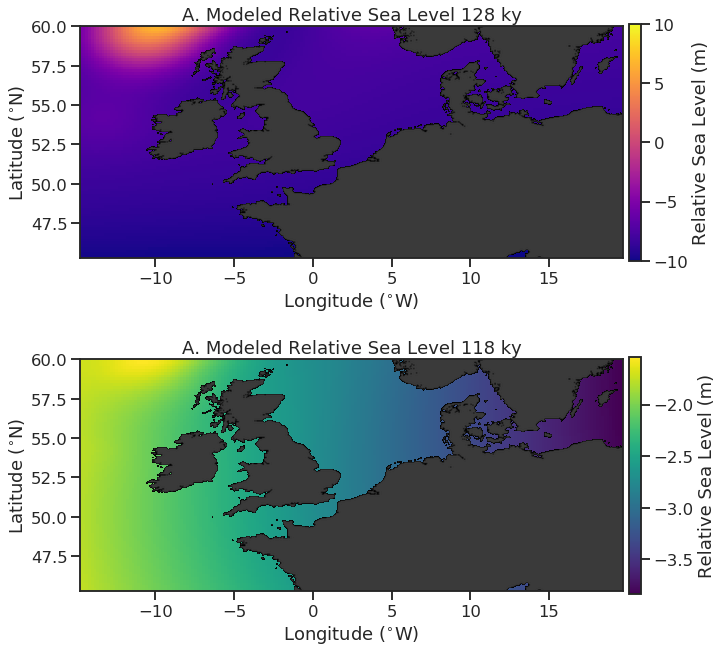

In [11]:
fig = plt.figure(figsize=(10, 9))
plt.subplot(2, 1, 1)
shrink = 0.9
plt.imshow(
    early_LIG,
    interpolation="nearest",
    cmap="plasma",
    extent=model_dims,
    vmin=-10,vmax=10
)
plt.colorbar(
    shrink=shrink,
    pad=0.01,
    label="Relative Sea Level (m)",
)
my_grey = cm.Greys_r
my_grey.set_under("k", alpha=0)
plt.imshow(
    landzoom,
    interpolation="gaussian",
    cmap=my_grey,
    vmin=0.1,
    vmax=5,
    extent=imarray_ext,
)
plt.gca().set_title("A. Modeled Relative Sea Level 128 ky")
plt.gca().grid(False)
plt.gca().set_xlim([model_dims[0], model_dims[1]])
plt.gca().set_ylim([model_dims[2], model_dims[3]])
plt.gca().set_ylabel("Latitude ($^{\circ}$N)")
plt.gca().set_xlabel("Longitude ($^{\circ}$W)")
plt.subplot(2, 1, 2)
plt.imshow(
    late_LIG,
    interpolation="nearest",
    cmap="viridis",
    extent=model_dims,
)
plt.colorbar(
    shrink=shrink,
    pad=0.01,
    label="Relative Sea Level (m)",)
my_grey = cm.Greys_r
my_grey.set_under("k", alpha=0)
plt.imshow(
    landzoom,
    interpolation="gaussian",
    cmap=my_grey,
    vmin=0.1,
    vmax=5,
    extent=imarray_ext,
)
plt.gca().set_title("A. Modeled Relative Sea Level 118 ky")
plt.gca().grid(False)
plt.gca().set_xlim([model_dims[0], model_dims[1]])
plt.gca().set_ylim([model_dims[2], model_dims[3]])
plt.gca().set_ylabel("Latitude ($^{\circ}$N)")
plt.gca().set_xlabel("Longitude ($^{\circ}$W)")
fig.tight_layout(pad=0, w_pad=-2, h_pad=1)


Self reminder for interpretation: subsidence = bottom panel minus the top panel. For example, the orth west corner is -2 at 118 ky and +10 at 128 ky. This area has subsided -12 meters (or uplifted 12 meters). 

## Generate 'data' from true GIA model (varying age and location).

In [12]:
data_number = 10 ## datapoints to generate

In [13]:
data = {}
data['lon'] = np.random.uniform(model_dims[0], model_dims[1], data_number)
data['lat'] = np.random.uniform(model_dims[2], model_dims[3], data_number)
data["age"] = np.random.uniform(117, 128, data_number) #end_LIG
data["age_uncertainty"] = (
    np.ones(data_number) * .66 #1ky
)  


GIA_MODEL = models[true_choice]
if "_S" in model_names[true_choice]:
    ESL_CURVE = np.copy(Wael)
if "_T" in model_names[true_choice]:
    ESL_CURVE = np.copy(Wael_T)

z_functions = interpolation_functions(
    data["lat"], data["lon"], GIA_MODEL, ESL_CURVE, Age_ESL
)
    
Es = []
for i in range(len(z_functions)):
    Es.append(z_functions[i](data['age'][i]))
data["rsl"] = np.array(Es)

data["elevation_uncertainty"] = np.ones(data_number) * 0.25
data["type"] = data_number*['highstand']

Make GMSL during LIG greater than zero and changing:

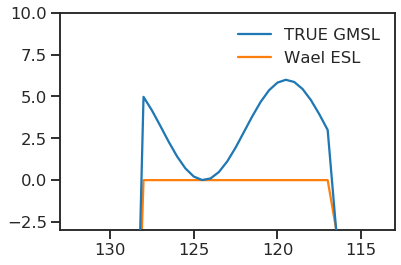

In [14]:
sns.set_context("talk")
LIG = (Age_ESL >= 117) & (Age_ESL <= 128)

k = true_choice
GIA_MODEL = models[k]
if "_S" in model_names[k]:
    ESL_CURVE = Wael
if "_T" in model_names[k]:
    ESL_CURVE = Wael_T

synth_gmsl = np.copy(ESL_CURVE)
xt = Age_ESL[LIG] - Age_ESL[LIG].min()

GMSL_TO_ADD=3 * np.sin(xt / (0.5 * np.pi)) + 3

synth_gmsl[LIG] = ESL_CURVE[LIG] + GMSL_TO_ADD
plt.plot(Age_ESL, synth_gmsl, label="TRUE GMSL", zorder=3)
plt.plot(Age_ESL, ESL_CURVE, label="Wael ESL")
plt.gca().set_xlim([113, 133])
plt.gca().set_ylim([-3, 10])
plt.legend(loc="best", frameon=False)
plt.gca().invert_xaxis()

In [15]:
synth_gmsl_fun = interp1d(Age_ESL, synth_gmsl)
ESL_CURVE_fun = interp1d(Age_ESL, ESL_CURVE)
synth_gmsl_fun(Age_ESL)

## add true gmsl to RSL model
data["elevation"] = np.copy(data["rsl"])
for i in range(data["lat"].size):
    data["elevation"][i] += synth_gmsl_fun(data["age"][i]) - ESL_CURVE_fun(
        data["age"][i]
    )

Look at data:

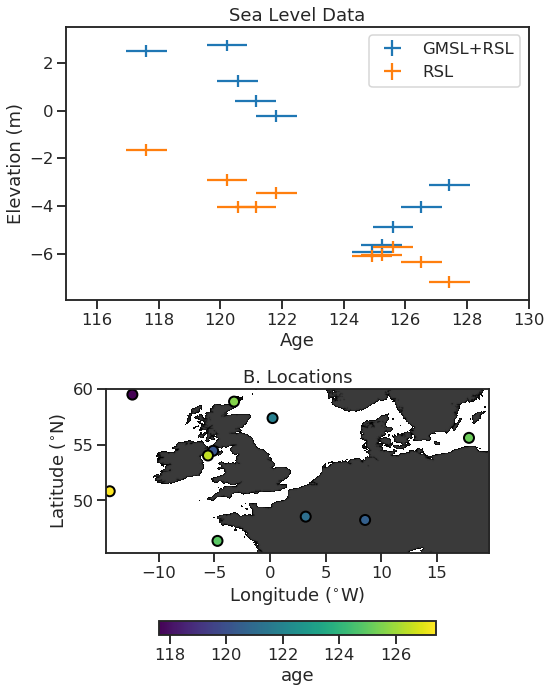

In [16]:
sns.set_context('talk')
fig=plt.figure(figsize=(8,10))
plt.subplot(2,1,1)
plt.errorbar(
    data["age"],
    data["elevation"],
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    linestyle="none",label='GMSL+RSL'
)
plt.errorbar(
    data["age"],
    data["rsl"],
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    linestyle="none",label='RSL'
)

plt.legend(loc='best')



plt.gca().set_xlabel('Age')
plt.gca().set_ylabel('Elevation (m)')
_=plt.gca().set_title('Sea Level Data')
plt.gca().set_xlim([115,130])
# plt.gca().set_ylim([-5,7])

plt.subplot(2,1,2)

plt.imshow(
    landzoom,
    interpolation="gaussian",
    cmap=my_grey,
    vmin=0.1,
    vmax=5,
    extent=imarray_ext,
)

plt.scatter(data['lon'],data['lat'],c=data['age'],cmap='viridis',s=100,edgecolor='k',lw=2)
plt.colorbar(label='age',shrink=.6,pad=0.25, orientation="horizontal")
plt.gca().set_title("B. Locations")
plt.gca().grid(False)
plt.gca().set_xlim([model_dims[0], model_dims[1]])
plt.gca().set_ylim([model_dims[2], model_dims[3]])
plt.gca().set_ylabel("Latitude ($^{\circ}$N)")
plt.gca().set_xlabel("Longitude ($^{\circ}$W)")
fig.tight_layout()


In [17]:
data=pd.DataFrame.from_dict(data)

## Infer GMSL

In [18]:
N = data["elevation"].size
comparison = {}
stats_models = {}
gps = {}
traces = {}

for k in range(len(model_names)):
# for k in range(5):
    clear_output(wait=True)
    print("running simulation number " + str(k + 1) + " of " + str(len(models)))
    print("running model: " + model_names[k])
    GIA_MODEL = models[k]
    if "_S" in model_names[k]:
        ESL_CURVE = np.copy(Wael)
    if "_T" in model_names[k]:
        ESL_CURVE = np.copy(Wael_T)

    z_functions = interpolation_functions(
        data["lat"], data["lon"], GIA_MODEL, ESL_CURVE, Age_ESL
    )
    az_trace, trace, model, gp = inference_model_real_data(
    data,
    z_functions,
    target_accept=0.8,
    cores=8,chains=8,
    keys=["highstand"],
    init="adapt_full",
    tune=500,
    draws=500)
    
    comparison[model_names[k]] = az_trace
    stats_models[model_names[k]] = model
    gps[model_names[k]] = gp
    traces[model_names[k]] = trace

running simulation number 216 of 216
running model: output96Cp57_Lambeck_Wael_T


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [noise, elev_sd, m_gmsl, gp_var, gp_ls, highstand_age_sd]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 204 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2253231527803697, but should be close to 0.8. Try to increase the number of tuning steps.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6393901687687946, but should be close to 0.8. Try to increase the number of tuning steps.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There w

## Calculate relative model weights for all inferences 
We use leave-one-out (loo) cross validation with an Akaike-type weighting. The weights are stabilized using a Bayesian bootstrap. https://arviz-devs.github.io/arviz/generated/arviz.compare.html

In [19]:
comp = pm.compare(comparison, ic="loo", b_samples=100000) #overkill on samples, but it is fast enough

### Add GIA model parameters and identify TRUE model in Dataframe

In [20]:
compare_model_names = comp.index.values
model_params_df = {}
for i in range(len(compare_model_names)):
    md_id = np.where(model_names == compare_model_names[i])[0][0]
    ice_history = compare_model_names[i].split("_")[1]
    esl_curve = compare_model_names[i].split("_")[2]
    deglacial_rate = compare_model_names[i].split("_")[3]
    model_params_df[compare_model_names[i]] = [
        lower[md_id],
        upper[md_id],
        litho[md_id],
        ice_history,
        esl_curve,
        deglacial_rate,
    ]

df2 = pd.DataFrame.from_dict(
    model_params_df,
    orient="index",
    columns=["LMV", "UMV", "lithosphere", "ice_history", "esl_curve", "deglacial_rate"],
)

comp3 = comp.join(df2)

identify = {}
for i in range(len(model_names)):
    if i == true_choice:
        identify[model_names[i]] = True
    else:
        identify[model_names[i]] = False

df3 = pd.DataFrame.from_dict(identify, orient="index", columns=["true_model"],)

comp3 = comp.join(df2).join(df3)


### Save dataframe as csv

In [21]:
comp3.to_csv('true_model_experiment1.csv')

## Summary figure showing model weightings for all 216 GIA models

In [22]:
# one subplot for each experiment
experiments = [
    ["Lambeck", "S", 96],
    ["Colleoni", "S", 96],
    ["ICE6G", "S", 96],
    ["Lambeck", "T", 96],
    ["Colleoni", "T", 96],
    ["ICE6G", "T", 96],
    ["Lambeck", "S", 71],
    ["Colleoni", "S", 71],
    ["ICE6G", "S", 71],
    ["Lambeck", "T", 71],
    ["Colleoni", "T", 71],
    ["ICE6G", "T", 71],
    ["Lambeck", "S", 48],
    ["Colleoni", "S", 48],
    ["ICE6G", "S", 48],
    ["Lambeck", "T", 48],
    ["Colleoni", "T", 48],
    ["ICE6G", "T", 48],
]

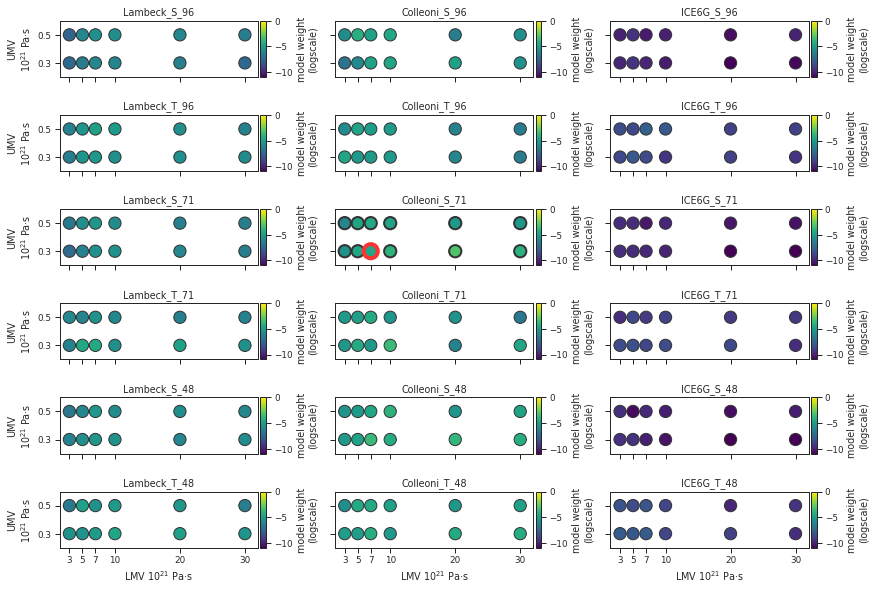

In [23]:
sns.set_context("paper")
fig = plt.figure(figsize=(12, 8))

weight_jump=np.argmin(np.diff(np.log(np.array(comp3["weight"].values.astype(float)))))
vmin=np.log(np.array(comp3["weight"].values.astype(float)))[weight_jump]

for i in range(0, 18):
    experiment = experiments[i]
    plt.subplot(6, 3, 1 + i)
    filtered = comp3[
        (comp3.ice_history == experiment[0])
        & (comp3.deglacial_rate == experiment[1])
        & (comp3.lithosphere == experiment[2])
    ]
    if filtered["true_model"].unique().size == 1:
        plt.scatter(
            filtered["LMV"].values,
            filtered["UMV"] / 1e21,
            c=np.log(np.array(filtered["weight"].values.astype(float))),
            s=150,
            cmap="viridis",
            edgecolor=(0.2, 0.2, 0.2),
            lw=1,
            vmin=vmin,
            vmax=0,
            zorder=2,
        )
    else:
        ec = np.dot(
            filtered["true_model"].values.astype(int)[:, np.newaxis],
            np.array([0.8, 0.0, 0.0])[np.newaxis, :],
        )
        ew = filtered["true_model"].values.astype(int) * 2
        s = filtered["true_model"].values.astype(int) * 50
        plt.scatter(
            filtered["LMV"].values,
            filtered["UMV"] / 1e21,
            c=np.log(np.array(filtered["weight"].values.astype(float))),
            s=150 + s,
            cmap="viridis",
            edgecolor=np.array([0.2, 0.2, 0.2]) + ec,
            lw=2 + ew,
            vmin=vmin,
            vmax=0,
            zorder=2,
        )

    plt.colorbar(label="model weight\n(logscale)", pad=.01, aspect=10)

    plt.gca().set_xticklabels((np.round(np.unique(lower), 0) / 1e21).astype(int))
    plt.gca().set_yticks(np.unique(upper) / 1e21)
    plt.gca().set_xticks(np.unique(lower))
    plt.gca().set_xlim(1.5e21, 32e21)
    plt.gca().set_ylim(0.2, 0.6)
    if i > 14:
        plt.gca().set_xlabel("LMV $10^{21}$ Pa·s")
    else:
        plt.gca().set_xticklabels([])
    if i % 3 == 0:
        plt.gca().set_ylabel("UMV\n$10^{21}$ Pa·s")
    else:
        plt.gca().set_yticklabels([])

    plt.minorticks_off()
    plt.gca().set_title(experiment[0] + "_" + experiment[1] + "_" + str(experiment[2]))


fig.tight_layout()
fig.tight_layout(pad=0, w_pad=1, h_pad=2)

Each circle represents a GIA model. The color of the circle is the probability that the observations were generated by the model relative to the probability that the observations were generated by any of the other models (the weightings sum to 1). The circle highlighted with a <span style='color:red;font-weight:bold'>RED</span> border is the model that was actually used to generate the data (the 'TRUE' GIA model). Remember that these weightings show similarities between GIA models at the lat/lon, the age of the samples, AND the prescribed GMSL.

## Use the weightings to make a combined GMSL inference
We will never know the 'true' GIA model, but we should include the uncertainty of all of the likely models in our prediction. The weightings offer guidance on how important each model should be in that final inference.

### Generate predictions from gaussian process posterior for top models

In [24]:
# new timespan to evaluate the gaussian process
X_new = np.linspace(115, 130, 200)[:, np.newaxis]

cut_off=np.where(np.cumsum(comp3['weight'].values)>0.95)[0][0] #cut off for 95% of the weights
top_models = np.arange(0,cut_off) 


predictions={}
for i in top_models:
    clear_output(wait=True)
    print("sampling model " + str(i + 1) + " of " + str(len(top_models)))

    key = comp3.index[i]  # model name (str)
    model = stats_models[key]  # (str) names are used as keys
    gp = gps[key]
    az_trace = comparison[key]
    trace = traces[key]

    with model:  # pymc3 model context
        if 'f_pred' in list(model.named_vars.keys()):
            f_pred=model.named_vars['f_pred']
        else:
            f_pred = gp.conditional("f_pred", X_new)

    
    pred_samples = pm.sample_posterior_predictive(
        trace,  # if using pymc3 trace remove '.posterior'
        model=model,
        vars=[f_pred],
        samples=1000,
    )
    
    predictions[key]=pred_samples        


sampling model 118 of 118


In [25]:
#extra samples for true model
i=np.argmax(comp3['true_model'].values.astype(int))
key = comp3.index[i]  # model name (str)
model = stats_models[key]  # (str) names are used as keys
gp = gps[key]
trace = traces[key]

with model:  # pymc3 model context
    if 'f_pred' in list(model.named_vars.keys()):
        f_pred=model.named_vars['f_pred']
    else:
        f_pred = gp.conditional("f_pred", X_new)


pred_samples = pm.sample_posterior_predictive(
    trace,  # if using pymc3 trace remove '.posterior'
    model=model,
    vars=[f_pred],
    samples=1000,
)

predictions[key]=pred_samples 

In [26]:
## add model ESL back to predictions
predictions_with_esl = {}
for key in list(predictions.keys()):
    if "_S" in key:
        ESL_CURVE = np.copy(Wael)
    if "_T" in key:
        ESL_CURVE = np.copy(Wael_T)
    wael_fun = interp1d(Age_ESL,ESL_CURVE)
    esl_mod = wael_fun(X_new).ravel()
    predictions_with_esl[key]={}
    predictions_with_esl[key]['f_pred']=predictions[key]['f_pred']+esl_mod

### Generate a weighted prediction

In [27]:
filter_for_models=list(predictions_with_esl.keys())
comp_filtered = pm.compare(filtered_posteriors(filter_for_models,comparison), ic="loo", b_samples=10000) 
inference_filtered = weighted_trace(filtered_posteriors(filter_for_models,predictions_with_esl),comp_filtered)



In [28]:
filter_for_models=model_names[true_choice]
comp_filtered = pm.compare(filtered_posteriors(filter_for_models,comparison), ic="loo", b_samples=10000) 
inference_true = weighted_trace(filtered_posteriors(filter_for_models,predictions_with_esl),comp_filtered)


### Plot predictions from the TRUE GIA model and the weighted metamodel

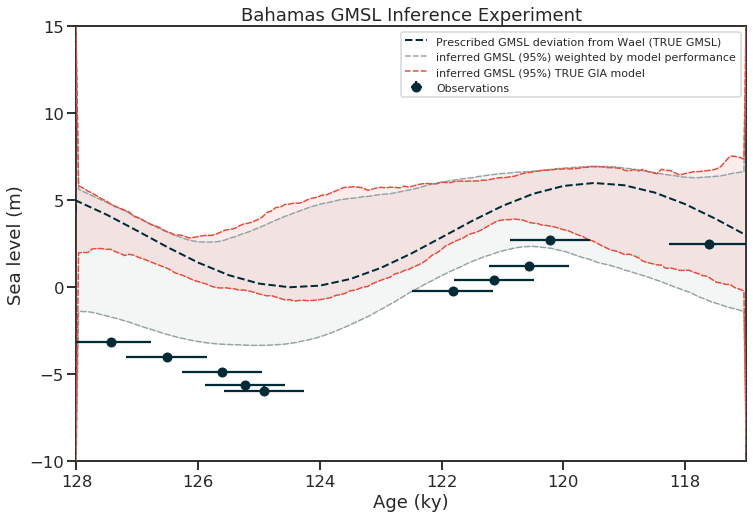

In [40]:
fig = plt.figure(figsize=(12, 8))
sns.set_context("talk")
X_new = np.linspace(115, 130, 200)[:, np.newaxis]
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
cs = sns.color_palette(flatui)
ax=plt.gca()
plt.plot(
    Age_ESL,
    synth_gmsl,
    label="Prescribed GMSL deviation from Wael (TRUE GMSL)",
    zorder=30,
    lw=2,
    color='#002b36',linestyle='--'
)

plt.errorbar(
    data["age"],
    data["elevation"],
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    marker="o",
    linestyle="none",
    label="Observations",
    color="#002b36",
    zorder=17,
)


inferences=[inference_filtered,inference_true,]
labels=["inferred GMSL (95%) weighted by model performance","inferred GMSL (95%) TRUE GIA model",
        ]

count=2 #color offset
for i,l in zip(inferences,labels):
    color=cs[count]
    inference=i
    bot = np.nanpercentile(inference, 2.5, axis=0)
    top = np.nanpercentile(inference, 97.5, axis=0)
    dy=np.linspace(-5,15,100)
#     max_like = gaussian(max_like,1)

    ax.fill_between(
            X_new.ravel(),
            bot,
            top,
            fc=(1,1,1),
            zorder=2,
            alpha=1,
            lw=0,
            ec=color,
            aa=True,
            capstyle="round",
        )
    ax.fill_between(
            X_new.ravel(),
            bot,
            top,
            fc=color,
            zorder=3,
            alpha=.1,
            lw=0,
            ec=color,
            aa=True,
            capstyle="round",
        )
    ax.fill_between(
        X_new.ravel(),
        bot,
        top,
        fc='none',
        zorder=4,
        alpha=1,
        lw=1.5,linestyle='--',
        ec=color,
        aa=True,
        capstyle="round",#hatch=''
    )
    
    
    ## make legend here
    plt.plot([],[],color=color,lw=1.5,linestyle='--',label=l)
#     plt.plot([],[],color=color,lw=4,label='Most likely GMSL')
    

    
    lig_only=((X_new<128) & (X_new>117)).ravel()
#     ax.plot(X_new[lig_only],max_like[lig_only],
#              zorder=13,color=color,lw=4)
    ax.legend(loc="best", frameon=True, fontsize=8)

#     plt.plot(X_new,max_like,zorder=13,color=cs[count],lw=4)
#     plt.plot(X_new,max_like,zorder=15,color='w',lw=3)
    count+=1



plt.gca().set_xlim(LIG_END, LIG_START)
plt.gca().set_ylim(-10, 15)
plt.gca().invert_xaxis()
plt.legend(loc="best", frameon=True, fontsize=11)
plt.gca().set_xlabel("Age (ky)")
plt.gca().set_ylabel("Sea level (m)")
_=plt.gca().set_title("Bahamas GMSL Inference Experiment")


# Experiment 2: Can we find the true GIA model using data locations, age, and age errors?
* Select a GIA model to be TRUE
* Generate 'data' from that TRUE GIA model <span style='font-weight:bold;color:red'>Using LAT/LON, RSL error, ages,and age errors from real dataset</span>
* <span style='font-weight:bold;color:green;text-decoration:line-through'>Add sinusoidal GMSL to the data</span>
* Plug each GIA model into our existing GMSL inference framework
* Compare the weights or information criteria of each model (does the TRUE model win?)
* Use model weightings to make a GMSL inference with ALL models

## True GIA Model:
Select one of the real GIA models as 'True'

In [44]:
np.random.seed(42)

N = len(model_names)
true_choice = np.random.choice(N, 1)[0]
true_model = models[true_choice]
print("Model " + str(model_names[true_choice]) + " selected as TRUE model.")

np.random.seed()

Model output71Cp37_Colleoni_Wael_S selected as TRUE model.


In [45]:
zoomlevel = 4
i = 13  # age slice
early_LIG = ndimage.zoom(true_model[i], zoomlevel, order=3)
i = 3  # age slice
late_LIG = ndimage.zoom(true_model[i], zoomlevel, order=3)

## Look at TRUE GIA model output

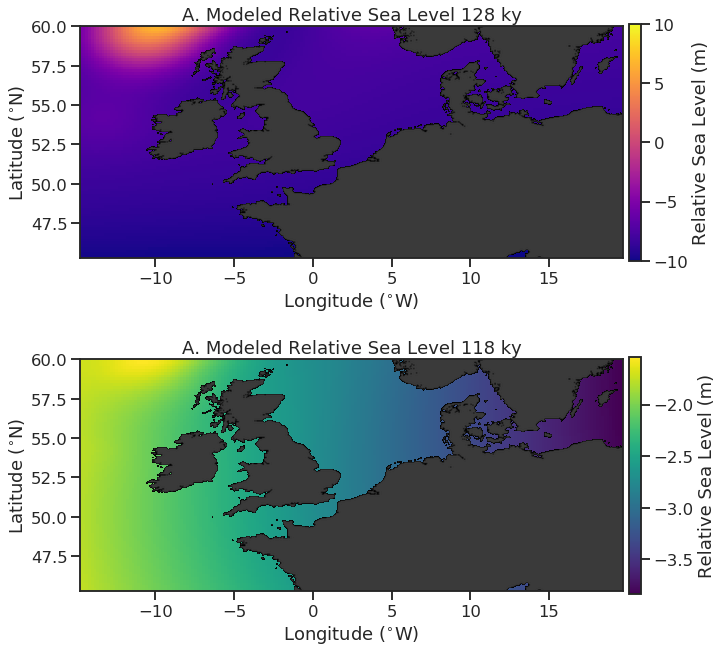

In [46]:
fig = plt.figure(figsize=(10, 9))
plt.subplot(2, 1, 1)
shrink = 0.9
plt.imshow(
    early_LIG,
    interpolation="nearest",
    cmap="plasma",
    extent=model_dims,
    vmin=-10,vmax=10
)
plt.colorbar(
    shrink=shrink,
    pad=0.01,
    label="Relative Sea Level (m)",
)
my_grey = cm.Greys_r
my_grey.set_under("k", alpha=0)
plt.imshow(
    landzoom,
    interpolation="gaussian",
    cmap=my_grey,
    vmin=0.1,
    vmax=5,
    extent=imarray_ext,
)
plt.gca().set_title("A. Modeled Relative Sea Level 128 ky")
plt.gca().grid(False)
plt.gca().set_xlim([model_dims[0], model_dims[1]])
plt.gca().set_ylim([model_dims[2], model_dims[3]])
plt.gca().set_ylabel("Latitude ($^{\circ}$N)")
plt.gca().set_xlabel("Longitude ($^{\circ}$W)")
plt.subplot(2, 1, 2)
plt.imshow(
    late_LIG,
    interpolation="nearest",
    cmap="viridis",
    extent=model_dims,
)
plt.colorbar(
    shrink=shrink,
    pad=0.01,
    label="Relative Sea Level (m)",)
my_grey = cm.Greys_r
my_grey.set_under("k", alpha=0)
plt.imshow(
    landzoom,
    interpolation="gaussian",
    cmap=my_grey,
    vmin=0.1,
    vmax=5,
    extent=imarray_ext,
)
plt.gca().set_title("A. Modeled Relative Sea Level 118 ky")
plt.gca().grid(False)
plt.gca().set_xlim([model_dims[0], model_dims[1]])
plt.gca().set_ylim([model_dims[2], model_dims[3]])
plt.gca().set_ylabel("Latitude ($^{\circ}$N)")
plt.gca().set_xlabel("Longitude ($^{\circ}$W)")
fig.tight_layout(pad=0, w_pad=-2, h_pad=1)


Self reminder for interpretation: subsidence = bottom panel minus the top panel. For example, the north west corner is -2 at 118 ky and +10 at 128 ky. This area has subsided -12 meters (or uplifted 12 meters). 

## Generate 'data' from true GIA model (varying age and location).

In [47]:
df=pd.read_excel(data_dir/'NWEuropeDatabase_v4.xlsx',header=1)

In [174]:
data = {}
filtered = df[(df['Age\n(ka BP)']>115) & (df['Age\n(ka BP)']<130)]
data["lon"] = filtered['Longitude'].dropna().values
data["lat"] = filtered['Latitude'].dropna().values
data["age"] = filtered['Age\n(ka BP)'].dropna().values
data["age_uncertainty"] = filtered['Age Error\n(1σ ka)'].dropna().values
data["elevation"] = filtered['Relative Sea \nLevel (m)'].dropna().values
data["elevation_uncertainty"] = filtered['RSL Error \n(1σ m)'].dropna().values
data["type"] = filtered['Longitude'].dropna().values.size*['index'] #index point with normal age errors

GIA_MODEL = models[true_choice]
if "_S" in model_names[true_choice]:
    ESL_CURVE = np.copy(Wael)
if "_T" in model_names[true_choice]:
    ESL_CURVE = np.copy(Wael_T)

ESL_fun = UnivariateSpline(Age_ESL, ESL_CURVE, k=1, ext=3, s=0)

z_functions = interpolation_functions(data["lat"], data["lon"], GIA_MODEL, ESL_CURVE, Age_ESL)
Es = []
for i in range(len(z_functions)):
    Es.append(z_functions[i](data['age'][i]))
data["rsl"] = np.array(Es)
data['elevation']=np.copy(data['rsl'])

data=pd.DataFrame.from_dict(data)

No added GMSL to the data in this experiment

Look at data:

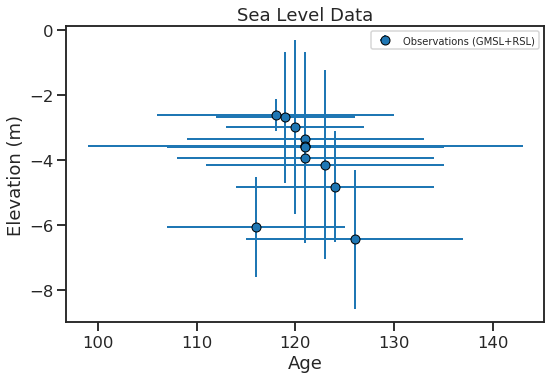

In [175]:
sns.set_context("talk")
fig = plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.errorbar(
    data["age"],
    data["elevation"] + ESL_fun(data["age"]),
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    linestyle="none",
    label="Observations (GMSL+RSL)",
    marker='o',mec='k',lw=2
)

plt.legend(loc="best", frameon=True,fontsize=10)


plt.gca().set_xlabel("Age")
plt.gca().set_ylabel("Elevation (m)")
_ = plt.gca().set_title("Sea Level Data")
# plt.gca().set_xlim([113, 133])


fig.tight_layout()

## MAY WANT TO REMOVE SAMPLES PRE 128 WHERE GIA/RSL BASICALLY EQUALS THE ESL CURVE

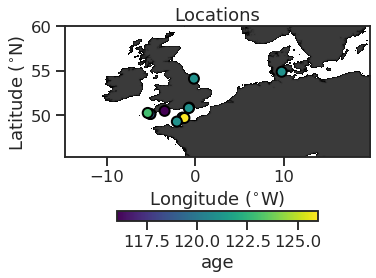

In [176]:
plt.imshow(
    landzoom,
    interpolation="gaussian",
    cmap=my_grey,
    vmin=0.1,
    vmax=5,
    extent=imarray_ext,
)
plt.scatter(data['lon'],data['lat'],c=data['age'],cmap='viridis',s=100,edgecolor='k',lw=2)
plt.colorbar(label='age',shrink=.6,pad=0.25, orientation="horizontal")
plt.gca().set_title("Locations")
plt.gca().grid(False)
plt.gca().set_xlim([model_dims[0], model_dims[1]])
plt.gca().set_ylim([model_dims[2], model_dims[3]])
plt.gca().set_ylabel("Latitude ($^{\circ}$N)")
plt.gca().set_xlabel("Longitude ($^{\circ}$W)")
fig.tight_layout()

## Infer GMSL for a single GIA model (a quick check)

In [177]:
data2 = data.copy()
N = data["elevation"].size
model_choice = 31
model = models[model_choice]
GIA_MODEL = models[model_choice]
if "_S" in model_names[model_choice]:
    ESL_CURVE = np.copy(Wael)
if "_T" in model_names[model_choice]:
    ESL_CURVE = np.copy(Wael_T)
z_functions = interpolation_functions(
    data["lat"], data["lon"], GIA_MODEL, ESL_CURVE, Age_ESL
)

# to avoid a strange linux locking bug for HMC, use cores = 1 when dataset is large
az_trace, trace, model, gp = inference_model_real_data(
    data2,
    z_functions,
    target_accept=0.8,
    cores=8,chains=8,
    keys=["index"],
    init="adapt_full",
    tune=500,
    draws=500,
)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [noise, elev_sd, m_gmsl, gp_var, gp_ls, index_age_sd]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 102 seconds.
There were 201 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6466150384719594, but should be close to 0.8. Try to increase the number of tuning steps.
There were 228 divergences after tuning. Increase `target_accept` or reparameterize.
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
There were 251 divergences after tuning. Increase `target_accept` or reparameterize.
There were 268 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6706806116564487, but should be close to 0.8. Try to increase the number of tuning steps.
There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
There were 264 divergences after tuning. Increase `target_accept` or reparameterize.


In [178]:
X_new = np.linspace(115, 130, 100)[:, np.newaxis]

with model:  # pymc3 model context
    if 'f_pred' in list(model.named_vars.keys()):
        f_pred=model.named_vars['f_pred']
    else:
        f_pred = gp.conditional("f_pred", X_new)

pred_samples = pm.sample_posterior_predictive(
    trace,  # if using pymc3 trace remove '.posterior'
    model=model,
    vars=[f_pred],
    samples=1000,
)


In [179]:
key=model_names[model_choice]
predictions_with_esl = {}

if "_S" in key:
    ESL_CURVE = np.copy(Wael)
if "_T" in key:
    ESL_CURVE = np.copy(Wael_T)
wael_fun = interp1d(Age_ESL,ESL_CURVE)
esl_mod = wael_fun(X_new).ravel()
predictions_with_esl[key]={}
predictions_with_esl[key]['f_pred']=pred_samples['f_pred']+esl_mod

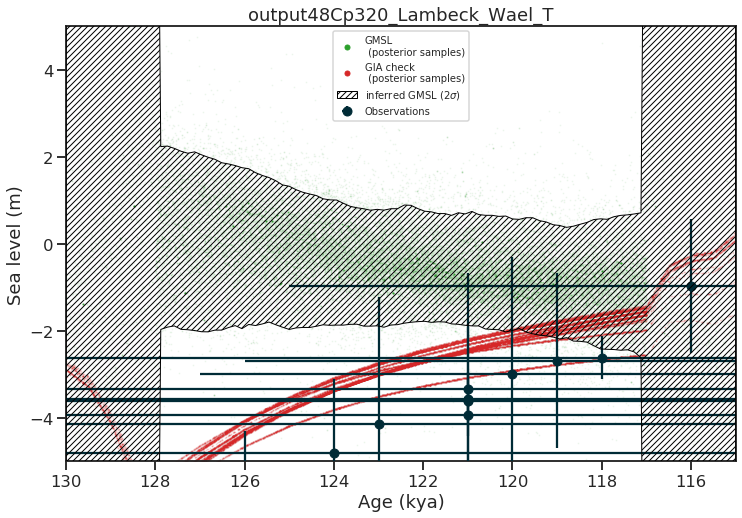

In [180]:
cs = sns.color_palette('tab10')
# i = model_choice
# esl_fun = interp1d(Age_ESL, ESL_CURVE)
# esl = esl_fun(az_trace.posterior['ages'].values.ravel())
plt.figure(figsize=(12, 8))
plt.plot(
    az_trace.posterior["ages"].values.ravel(),
    az_trace.posterior["gmsl_points"].values.ravel(),
    ".",
    markersize=2,
    alpha=.05,color=cs[2]
)
plt.plot(
    [],[],
    ".",
    markersize=10,
    alpha=1,
    color=cs[2],
    label="GMSL\n (posterior samples)",
)
plt.plot(
    az_trace.posterior["ages"].values.ravel(),
    az_trace.posterior["GIA"].values.ravel(),
    ".",
    markersize=2,
    alpha=0.1,color=cs[3],
)
plt.plot(
    [],[],
    ".",
    markersize=10,
    alpha=1,
    color=cs[3],
    label="GIA check\n (posterior samples)",
)

plt.errorbar(
    data["age"],
    data["elevation"],
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    marker="o",
    linestyle="none",
    label="Observations",
    color="#002b36",
    zorder=10,
)

inference = pred_samples['f_pred']
bot = np.nanpercentile(inference, 2.5, axis=0)
top = np.nanpercentile(inference, 97.5, axis=0)
dy=np.linspace(-5,15,100)
# max_like = [dy[np.argmax(scipy.stats.gaussian_kde(inference[:,i])(dy))] for i in range(X_new.size)]
# max_like = gaussian(max_like,3)

plt.gca().fill_between(
    X_new.ravel(),
    bot,
    top,
    fc="none",
    zorder=15,
    alpha=1,
    label="inferred GMSL (2$\sigma$)",
    lw=1,
    ec=(0,0,0),
    aa=True,
    capstyle="round",
    hatch="////",
)

# plt.plot(X_new,max_like,lw=3,color='k')

# for k in range(15,300):
#     plt.plot(X_new,pred_samples['f_pred'][k,:],color='k',alpha=.1,lw=1,rasterized=True)

plt.legend(loc='best',fontsize=10)
# plt.plot(X_new,mean,color='k')
plt.gca().set_ylim(-5, 5)
plt.gca().set_xlim(115, 130)
plt.gca().invert_xaxis()
_=plt.gca().set_title(model_names[i])
plt.gca().set_xlabel('Age (kya)')
_=plt.gca().set_ylabel('Sea level (m)')

## Infer GMSL for all GIA models

In [181]:
N = data["elevation"].size
comparison = {}
stats_models = {}
gps = {}
traces = {}

for k in range(len(model_names)):
    clear_output(wait=True)
    print("running simulation number " + str(k + 1) + " of " + str(len(models)))
    print("running model: " + model_names[k])
    GIA_MODEL = models[k]
    if "_S" in model_names[k]:
        ESL_CURVE = np.copy(Wael)
    if "_T" in model_names[k]:
        ESL_CURVE = np.copy(Wael_T)

    z_functions = interpolation_functions(
        data["lat"], data["lon"], GIA_MODEL, ESL_CURVE, Age_ESL
    )
    az_trace, trace, model, gp = inference_model_real_data(
    data,
    z_functions,
    target_accept=0.8,
    cores=8,chains=8,
    keys=["index"],
    init="adapt_full",
    tune=500,
    draws=500)
    
    comparison[model_names[k]] = az_trace
    stats_models[model_names[k]] = model
    gps[model_names[k]] = gp
    traces[model_names[k]] = trace
    

running simulation number 216 of 216
running model: output96Cp57_Lambeck_Wael_T


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [noise, elev_sd, m_gmsl, gp_var, gp_ls, index_age_sd]


Sampling 8 chains for 500 tune and 500 draw iterations (4_000 + 4_000 draws total) took 91 seconds.
There were 375 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6129296632538017, but should be close to 0.8. Try to increase the number of tuning steps.
There were 207 divergences after tuning. Increase `target_accept` or reparameterize.
There were 144 divergences after tuning. Increase `target_accept` or reparameterize.
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
There were 219 divergences after tuning. Increase `target_accept` or reparameterize.
There were 120 divergences after tuning. Increase `target_accept` or reparameterize.
There were 357 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5834203909914402, but should be close to 0.8. Try to increase the number of tuning steps.
T

## Calculate relative model weights for all inferences 
We use leave-one-out (loo) cross validation with an Akaike-type weighting. The weights are stabilized using a Bayesian bootstrap. https://arviz-devs.github.io/arviz/generated/arviz.compare.html

In [182]:
comp = pm.compare(comparison, ic="loo", b_samples=10000,) #overkill on samples, but it is fast enough

### Add GIA model parameters and identify TRUE model in Dataframe

In [183]:
compare_model_names = comp.index.values
model_params_df = {}
for i in range(len(compare_model_names)):
    md_id = np.where(model_names == compare_model_names[i])[0][0]
    ice_history = compare_model_names[i].split("_")[1]
    esl_curve = compare_model_names[i].split("_")[2]
    deglacial_rate = compare_model_names[i].split("_")[3]
    model_params_df[compare_model_names[i]] = [
        lower[md_id],
        upper[md_id],
        litho[md_id],
        ice_history,
        esl_curve,
        deglacial_rate,
    ]

df2 = pd.DataFrame.from_dict(
    model_params_df,
    orient="index",
    columns=["LMV", "UMV", "lithosphere", "ice_history", "esl_curve", "deglacial_rate"],
)

comp3 = comp.join(df2)

identify = {}
for i in range(len(model_names)):
    if i == true_choice:
        identify[model_names[i]] = True
    else:
        identify[model_names[i]] = False

df3 = pd.DataFrame.from_dict(identify, orient="index", columns=["true_model"],)

comp3 = comp.join(df2).join(df3)


### Save dataframe as csv

In [184]:
comp3.to_csv('true_model_experiment2.csv')

## Summary figure showing model weightings for all 216 GIA models

In [185]:
# one subplot for each experiment
experiments = [
    ["Lambeck", "S", 96],
    ["Colleoni", "S", 96],
    ["ICE6G", "S", 96],
    ["Lambeck", "T", 96],
    ["Colleoni", "T", 96],
    ["ICE6G", "T", 96],
    ["Lambeck", "S", 71],
    ["Colleoni", "S", 71],
    ["ICE6G", "S", 71],
    ["Lambeck", "T", 71],
    ["Colleoni", "T", 71],
    ["ICE6G", "T", 71],
    ["Lambeck", "S", 48],
    ["Colleoni", "S", 48],
    ["ICE6G", "S", 48],
    ["Lambeck", "T", 48],
    ["Colleoni", "T", 48],
    ["ICE6G", "T", 48],
]

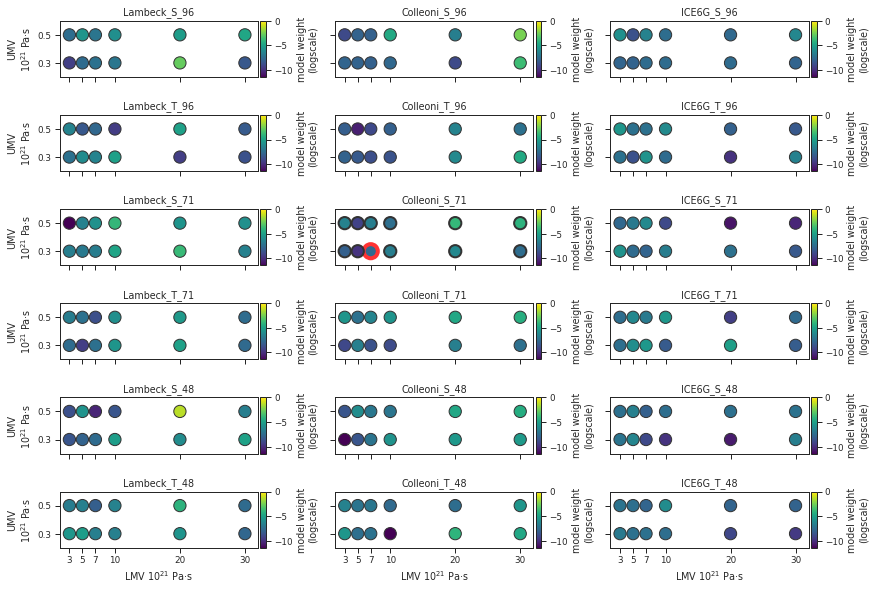

In [186]:
sns.set_context("paper")
fig = plt.figure(figsize=(12, 8))

weight_jump=np.argmin(np.diff(np.log(np.array(comp3["weight"].values.astype(float)))))
vmin=np.log(np.array(comp3["weight"].values.astype(float)))[weight_jump]

for i in range(0, 18):
    experiment = experiments[i]
    plt.subplot(6, 3, 1 + i)
    filtered = comp3[
        (comp3.ice_history == experiment[0])
        & (comp3.deglacial_rate == experiment[1])
        & (comp3.lithosphere == experiment[2])
    ]
    if filtered["true_model"].unique().size == 1:
        plt.scatter(
            filtered["LMV"].values,
            filtered["UMV"] / 1e21,
            c=np.log(np.array(filtered["weight"].values.astype(float))),
            s=150,
            cmap="viridis",
            edgecolor=(0.2, 0.2, 0.2),
            lw=1,
            vmin=vmin,
            vmax=0,
            zorder=2,
        )
    else:
        ec = np.dot(
            filtered["true_model"].values.astype(int)[:, np.newaxis],
            np.array([0.8, 0.0, 0.0])[np.newaxis, :],
        )
        ew = filtered["true_model"].values.astype(int) * 2
        s = filtered["true_model"].values.astype(int) * 50
        plt.scatter(
            filtered["LMV"].values,
            filtered["UMV"] / 1e21,
            c=np.log(np.array(filtered["weight"].values.astype(float))),
            s=150 + s,
            cmap="viridis",
            edgecolor=np.array([0.2, 0.2, 0.2]) + ec,
            lw=2 + ew,
            vmin=vmin,
            vmax=0,
            zorder=2,
        )

    plt.colorbar(label="model weight\n(logscale)", pad=.01, aspect=10)

    plt.gca().set_xticklabels((np.round(np.unique(lower), 0) / 1e21).astype(int))
    plt.gca().set_yticks(np.unique(upper) / 1e21)
    plt.gca().set_xticks(np.unique(lower))
    plt.gca().set_xlim(1.5e21, 32e21)
    plt.gca().set_ylim(0.2, 0.6)
    if i > 14:
        plt.gca().set_xlabel("LMV $10^{21}$ Pa·s")
    else:
        plt.gca().set_xticklabels([])
    if i % 3 == 0:
        plt.gca().set_ylabel("UMV\n$10^{21}$ Pa·s")
    else:
        plt.gca().set_yticklabels([])

    plt.minorticks_off()
    plt.gca().set_title(experiment[0] + "_" + experiment[1] + "_" + str(experiment[2]))


fig.tight_layout()
fig.tight_layout(pad=0, w_pad=1, h_pad=2)

Each circle represents a GIA model. The color of the circle is the probability that the observations were generated by the model relative to the probability that the observations were generated by any of the other models (the weightings sum to 1). The circle highlighted with a <span style='color:red;font-weight:bold'>RED</span> border is the model that was actually used to generate the data (the 'TRUE' GIA model). Remember that these weightings show similarities between GIA models at the lat/lon, the age of the samples, AND the prescribed GMSL.

## Use the weightings to make a combined GMSL inference
We will never know the 'true' GIA model, but we should include the uncertainty of all of the likely models in our prediction. The weightings offer guidance on how important each model should be in that final inference.

### Generate predictions from gaussian process posterior for top models

In [189]:
# all models with more than 1% weight
top_models = comp3[comp["weight"] > 0.01]["rank"].values
# new timespan to evaluate the gaussian process
X_new = np.linspace(110, 140, 200)[:, np.newaxis]

pred_traces = {}  # list to collect all of the predictions
for i in top_models:
    clear_output(wait=True)
    print("sampling model " + str(i + 1) + " of " + str(len(top_models)))
    to_plot = comp3[comp3["rank"] == i].index[0]  # model name (str)
    model = stats_models[to_plot]  # (str) names are used as keys
    gp = gps[to_plot]
    az_trace = comparison[to_plot]
    trace = traces[to_plot]

    with model:  # pymc3 model context
        if 'f_pred' in list(model.named_vars.keys()):
            f_pred=model.named_vars['f_pred']
        else:
            f_pred = gp.conditional("f_pred", X_new)

    X_new = np.linspace(110, 140, 200)[:, np.newaxis]
    pred_samples = pm.sample_posterior_predictive(
        trace,  # if using pymc3 trace remove '.posterior'
        model=model,
        vars=[f_pred],
        samples=1000,
    )
    pred_traces[to_plot]=pred_samples

sampling model 14 of 14


Add true model inference to the set if its weight was less than 1%

In [191]:
true_model_prediction_index = np.where(comp3.index==model_names[true_choice])[0][0]
if comp3['weight'][true_model_prediction_index]<0.01:
    to_plot = model_names[true_choice]  # model name (str)
    model = stats_models[to_plot]  # (str) names are used as keys
    gp = gps[to_plot]
    az_trace = comparison[to_plot]
    trace = traces[to_plot]

    with model:  # pymc3 model context
        if 'f_pred' in list(model.named_vars.keys()):
            f_pred=model.named_vars['f_pred']
        else:
            f_pred = gp.conditional("f_pred", X_new)

    X_new = np.linspace(110, 140, 200)[:, np.newaxis]
    pred_samples = pm.sample_posterior_predictive(
        trace,  # if using pymc3 trace remove '.posterior'
        model=model,
        vars=[f_pred],
        samples=1000,
    )
    pred_traces[to_plot] = pred_samples
    

In [ ]:
def weighted_trace(pred_list, comp, var="f_pred"):
    new_weights = comp['weight'].values.astype(float)
    new_weights = np.repeat(new_weights, pred_list[comp.index.values[0]]['f_pred'].shape[0], axis=0)
    new_weights = new_weights / np.sum(new_weights)

    test = [pred_list[p][var] for p in comp.index.values]
    C = np.random.choice(np.arange(np.vstack(test).shape[0]), 20000, p=new_weights)
    weighted_trace = np.vstack(test)[C, :]

    return weighted_trace

['output48Cp520_Lambeck_Wael_S',
 'output96Cp530_Colleoni_Wael_S',
 'output96Cp320_Lambeck_Wael_S',
 'output96Cp330_Colleoni_Wael_S',
 'output71Cp320_Lambeck_Wael_S',
 'output71Cp520_Colleoni_Wael_S',
 'output71Cp510_Lambeck_Wael_S',
 'output48Cp320_Colleoni_Wael_T',
 'output71Cp530_Colleoni_Wael_S',
 'output48Cp520_Lambeck_Wael_T',
 'output71Cp530_Colleoni_Wael_T',
 'output48Cp530_Colleoni_Wael_S',
 'output96Cp510_Colleoni_Wael_S',
 'output96Cp330_Colleoni_Wael_T',
 'output71Cp37_Colleoni_Wael_S']

### Generate a weighted prediction

In [ ]:
filter_for_models=list(pred_traces.keys())
comp_filtered = pm.compare(filtered_posteriors(filter_for_models,comparison), ic="loo", b_samples=10000) 
inference_filtered = weighted_trace(filtered_posteriors(filter_for_models,pred_traces),comp_filtered)



### Plot predictions from the TRUE GIA model and the weighted metamodel

Text(0.5, 1.0, 'EU GMSL Inference Experiment')

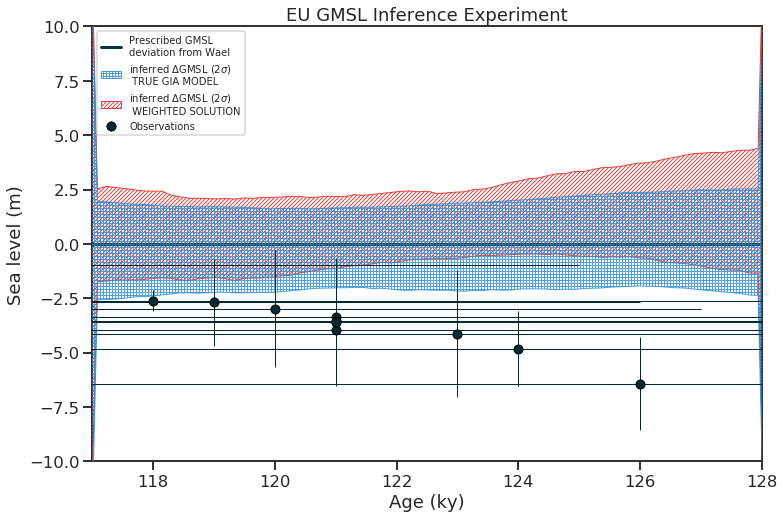

In [206]:
fig = plt.figure(figsize=(12, 8))
sns.set_context("talk")

        
plt.plot(
    Age_ESL,
    np.zeros(Age_ESL.shape),
    label="Prescribed GMSL\ndeviation from Wael",
    zorder=3,
    lw=3,
    color="#073642",
)



plt.errorbar(
    data["age"],
    data["elevation"],
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    marker="o",
    linestyle="none",
    label="Observations",
    color="#002b36",
    zorder=10,lw=1,mec='k'
)


inference = inference_filtered
bot = np.nanpercentile(inference, 2.5, axis=0)
top = np.nanpercentile(inference, 97.5, axis=0)
mean = np.nanmean(inference, axis=0)

plt.gca().fill_between(
    X_new.ravel(),
    bot,
    top,
    fc="none",
    zorder=4,
    alpha=.8,
    label="inferred $\Delta$GMSL (2$\sigma$)\n TRUE GIA MODEL",
    lw=1,
    ec="#268bd2",
    aa=True,
    capstyle="round",
    hatch=r"++++",
)

inference = pred_traces[model_names[true_choice]]['f_pred']
bot = np.nanpercentile(inference, 2.5, axis=0)
top = np.nanpercentile(inference, 97.5, axis=0)
mean = np.nanmean(inference, axis=0)


plt.gca().fill_between(
    X_new.ravel(),
    bot,
    top,
    fc="none",
    zorder=3,
    alpha=.9,
    label="inferred $\Delta$GMSL (2$\sigma$)\n WEIGHTED SOLUTION",
    lw=1,
    ec="#dc322f",
    aa=True,
    capstyle="round",
    hatch="//////",
)

plt.gca().set_xlim(LIG_END, LIG_START)
plt.gca().set_ylim(-10, 10)
plt.legend(loc="upper left", frameon=True, fontsize=10)
plt.gca().set_xlabel("Age (ky)")
plt.gca().set_ylabel("Sea level (m)")
plt.gca().set_title("EU GMSL Inference Experiment")